This notebook does necessary pre-processing to reformat the datasets

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import umap

In [4]:
sample = pd.read_csv("../data/sample_info.csv")

In [5]:
ccle2depmap = sample.set_index(['CCLE_Name']).to_dict()['DepMap_ID']

In [6]:
name_map = pd.read_csv("../data/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

# mutation

In [5]:
mutation = pd.read_csv("../data/CCLE_mutations.csv", sep='\t', low_memory=False)

In [6]:
mutation.shape

(1296237, 34)

In [7]:
mutation

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,ExAC_AF,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID
0,A1BG,1,37,19,58858743,58858743,+,Missense_Mutation,SNP,C,...,NaN,NaN,20:16,20:16,NaN,NaN,NaN,NaN,other non-conserving,ACH-000986
1,A1BG,1,37,19,58858810,58858810,+,Silent,SNP,C,...,NaN,NaN,10:21,14:23,34:87,NaN,NaN,22:19,silent,ACH-000988
2,A1BG,1,37,19,58858867,58858867,+,Missense_Mutation,SNP,C,...,NaN,NaN,4:9,4:9,NaN,NaN,NaN,NaN,other non-conserving,ACH-002182
3,A1BG,1,37,19,58858872,58858872,+,Missense_Mutation,SNP,C,...,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,9:16,other non-conserving,ACH-000985
4,A1BG,1,37,19,58858914,58858914,+,Missense_Mutation,SNP,C,...,0.000008,27:20,NaN,NaN,NaN,NaN,NaN,NaN,other non-conserving,ACH-001793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296232,ZZZ3,26009,37,1,78098868,78098868,+,Missense_Mutation,SNP,G,...,NaN,NaN,49:260,48:248,NaN,NaN,NaN,NaN,other non-conserving,ACH-002280
1296233,ZZZ3,26009,37,1,78098935,78098935,+,Silent,SNP,A,...,NaN,NaN,NaN,NaN,6:15,NaN,NaN,NaN,silent,ACH-000992
1296234,ZZZ3,26009,37,1,78098970,78098970,+,Frame_Shift_Del,DEL,A,...,NaN,NaN,31:8,40:87,11:64,NaN,NaN,6:16,damaging,ACH-000985
1296235,ZZZ3,26009,37,1,78098986,78098986,+,Silent,SNP,G,...,NaN,NaN,84:28,90:33,57:46,NaN,NaN,29:12,silent,ACH-000665


In [8]:
mutation = mutation[mutation['Variant_annotation']=='damaging']

In [9]:
mutation_count = mutation.groupby(['DepMap_ID', 'Hugo_Symbol']).size().reset_index(name='count')

In [10]:
mutation_count = pd.pivot(mutation_count, index='DepMap_ID', columns='Hugo_Symbol').fillna(0)

In [11]:
mutation_count

count                                                       ...  \
Hugo_Symbol  A1BG A1CF  A2M A2ML1 A3GALT2 A4GALT A4GNT AAAS AACS AADAC  ...   
DepMap_ID                                                               ...   
ACH-000001    0.0  0.0  0.0   0.0     0.0    0.0   0.0  1.0  0.0   0.0  ...   
ACH-000002    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-000003    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-000004    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-000005    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
...           ...  ...  ...   ...     ...    ...   ...  ...  ...   ...  ...   
ACH-002475    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-002508    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-002509    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-002510    0.0  0.0  0.0   0.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   
ACH-002511    0.0  0.0  0.0   1.0     0.0    0.0   0.0  0.0  0.0   0.0  ...   

                                                                             
Hugo_Symbol ZWINT ZXDA ZXDB ZXDC ZYG11A ZYG11B  ZYX ZZEF1 ZZZ3 hsa-mir-1199  
DepMap_ID                                                                    
ACH-000001    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-000002    1.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-000003    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-000004    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-000005    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
...           ...  ...  ...  ...    ...    ...  ...   ...  ...          ...  
ACH-002475    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-002508    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-002509    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-002510    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  
ACH-002511    0.0  0.0  0.0  0.0    0.0    0.0  0.0   0.0  0.0          0.0  

[1740 rows x 18091 columns]

In [12]:
mutation_count.columns = [x[1] for x in mutation_count.columns]

In [14]:
mutation_count = mutation_count.sort_values(by='DepMap_ID')

In [16]:
mutation_count.to_pickle("../data/CCLE_mutations_processed.pkl")
mutation_count.to_csv("../data/CCLE_mutations_processed.csv")

# copy number

In [18]:
cnv = pd.read_csv("../data/CCLE_gene_cn.csv", index_col=0)

In [19]:
cnv.index.name = 'DepMap_ID'

In [20]:
cnv.shape

(1745, 27639)

In [21]:
cnv.columns = [x.split(' ')[0] for x in cnv.columns]

cnv = cnv[sorted(cnv.columns)]
cnv = cnv.sort_values(by='DepMap_ID')

In [22]:
cnv.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,1.179621,1.179621,1.023685,0.994558,0.994558,0.994558,0.994558,1.010566,0.747249,1.383510,...,0.980463,1.023685,1.382566,1.382566,1.383510,1.211039,1.004519,1.043793,0.742698,1.015579
ACH-000002,1.009801,1.009801,1.001982,0.994210,0.994210,0.994210,0.994210,1.009073,1.022060,1.008385,...,0.986230,1.001982,0.611316,0.611316,1.008385,1.009073,1.009073,1.004020,0.600141,1.009073
ACH-000003,1.022828,1.022828,1.491543,1.190245,1.190245,1.190245,1.190245,0.669477,0.244061,0.976003,...,0.870673,1.459269,1.006063,1.006063,0.959388,0.820131,0.820131,1.138358,0.649156,0.680199
ACH-000004,1.232225,1.232225,0.836688,1.059946,1.059946,1.059946,1.059946,1.269446,0.822388,1.080898,...,1.070859,0.813560,1.018872,1.018872,1.084012,1.268977,1.268977,1.119363,0.836160,1.276832
ACH-000005,1.151880,1.151880,0.814678,1.126038,1.126038,1.126038,1.126038,1.337045,0.812665,1.101039,...,1.115492,0.814678,0.523496,0.523496,1.101039,1.337045,1.337045,0.840967,0.818548,1.337045


In [19]:
cnv.to_pickle("../data/CCLE_CN_processed.pkl")


In [23]:
cnv.round(6).to_csv("../data/CCLE_CN_processed.csv")

# RNA

In [25]:
rna = pd.read_csv("../data/CCLE_expression.csv", sep='\t', index_col=0)

In [26]:
rna.index.name = 'DepMap_ID'

In [27]:
rna.shape

(1304, 19144)

In [28]:
rna.columns = [x.split(' ')[0] for x in rna.columns]

rna = rna[sorted(rna.columns)]
rna = rna.sort_values(by='DepMap_ID')

In [29]:
rna.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.122673,0.056584,0.250962,0.111031,0.000000,1.035624,0.176323,5.845741,4.125155,0.815575,...,5.049631,6.695715,0.948601,1.839960,4.696550,3.273516,2.811471,6.825786,3.005400,4.710393
ACH-000002,1.416840,0.000000,0.286881,0.111031,0.000000,0.150560,0.000000,5.221877,1.967169,0.000000,...,3.176323,6.398487,0.056584,0.963474,3.951401,0.000000,1.090853,6.019924,2.195348,3.363171
ACH-000003,1.400538,4.335569,0.321928,0.150560,0.000000,4.207893,0.097611,5.332350,3.931683,1.827819,...,3.931683,7.555049,0.443607,1.475085,2.841973,0.695994,2.321928,7.326340,2.643856,2.961623
ACH-000004,4.180307,0.000000,0.286881,0.344828,0.070389,0.097611,0.000000,6.430620,3.212569,0.000000,...,4.242603,6.119356,0.765535,1.545968,3.617063,0.014355,2.070389,7.036503,3.436961,5.269407
ACH-000005,4.023255,0.014355,0.226509,0.014355,0.000000,0.028569,0.000000,6.397461,3.773996,0.000000,...,5.603181,6.825531,0.765535,1.704872,3.775051,0.014355,2.797013,6.863319,3.524816,5.982994


In [30]:
rna.to_pickle("../data/CCLE_RNA_processed.pkl")

In [31]:
rna.round(6).to_csv("../data/CCLE_RNA_processed.csv")

# protein

In [32]:
protein = pd.read_csv("../data/protein_quant_current_normalized.csv")

In [33]:
protein = protein.drop(
    ['Protein_Id', 'Gene_Symbol', 'Description', 'Group_ID', 'Uniprot_Acc'],
    axis=1).rename(columns={
        'Uniprot': 'Protein'
    }).set_index('Protein')
protein = protein.drop([
    'SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02',
    'HCT15_LARGE_INTESTINE_TenPx30'
],
                         axis=1)

In [34]:
rename_dict = {}
for x in protein.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
protein = protein.rename(columns=rename_dict)
protein = protein.drop(
    [x for x in protein.columns.tolist() if 'TenPx' in x],
    axis=1).transpose()

In [35]:
protein.index.name = 'CCLE_ID'

In [36]:
protein.index = protein.index.map(ccle2depmap)
protein.index.name = 'DepMap_ID'

In [37]:
protein = protein[[x for x in protein.columns if x in name_map_dict]]
protein.columns = [name_map_dict[x] for x in protein.columns]

In [38]:
protein = protein[sorted(protein.columns)]
protein = protein.sort_values(by='DepMap_ID')

In [33]:
protein.to_pickle("../data/CCLE_protein_processed.pkl")

In [39]:
protein.round(6).to_csv("../data/CCLE_protein_processed.csv")

# drug

In [147]:
drug = pd.read_csv("../data/secondary-screen-dose-response-curve-parameters.csv", low_memory=False)

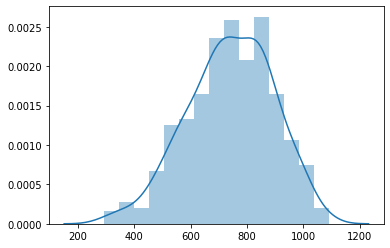

In [63]:
drug = drug[['depmap_id', 'name', 'ic50']].drop_duplicates().dropna()
drug.columns = ['DepMap_ID', 'drug_name', 'IC50']
sns.distplot(drug.groupby(['DepMap_ID']).size())

In [64]:
drug.to_csv("../data/broad_drug_processed_ic50.csv", index=False)

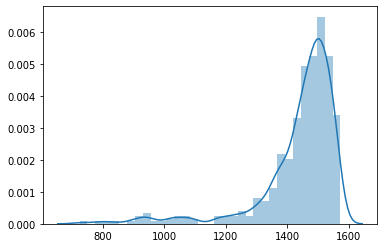

In [65]:
drug = pd.read_csv("../data/secondary-screen-dose-response-curve-parameters.csv", low_memory=False)
drug = drug[['depmap_id', 'name', 'auc']].dropna().drop_duplicates()
drug.columns = ['DepMap_ID', 'drug_name', 'AUC']
sns.distplot(drug.groupby(['DepMap_ID']).size())

In [66]:
drug.to_csv("../data/broad_drug_processed_auc.csv", index=False)

# filtering

In [206]:
mutation = pd.read_pickle(f"../data/CCLE_mutations_processed.pkl")
cn = pd.read_pickle(f"../data/CCLE_CN_processed.pkl")
rna = pd.read_pickle(f"../data/CCLE_RNA_processed.pkl")
protein = pd.read_pickle(f"../data/CCLE_protein_processed.pkl")
drug = pd.read_csv("../data/broad_drug_processed_auc.csv")

In [163]:
common_samples = set(drug['DepMap_ID'].unique()).intersection(
    mutation.index.values).intersection(cn.index.values).intersection(
        rna.index.values).intersection(protein.index.values)

In [167]:
mutation = mutation.loc[common_samples,:]
cn = cn.loc[common_samples,:]
rna = rna.loc[common_samples,:]
protein = protein.loc[common_samples,:]

In [188]:
mutation = mutation.loc[:,mutation.sum(axis=0) > 5]
mutation[mutation>1] = 1
rna = rna.loc[:,(rna > 0).sum(axis=0) > 5]
cn = cn[set(cn.columns).intersection(rna.columns)]
protein = protein[set(protein.columns).intersection(rna.columns)]

In [191]:
drug = drug[drug['DepMap_ID'].isin(common_samples)]

In [202]:
mutation.to_pickle("../data/CCLE_mutations_processed_filtered.pkl")
mutation.to_csv("../data/CCLE_mutations_processed_filtered.csv")

In [203]:
cn.to_pickle("../data/CCLE_CN_processed_filtered.pkl")
cn.round(6).to_csv("../data/CCLE_CN_processed_filtered.csv")

In [204]:
rna.to_pickle("../data/CCLE_RNA_processed_filtered.pkl")
rna.round(6).to_csv("../data/CCLE_RNA_processed_filtered.csv")

In [198]:
protein.to_pickle("../data/CCLE_protein_processed_filtered.pkl")
protein.round(6).to_csv("../data/CCLE_protein_processed_filtered.csv")

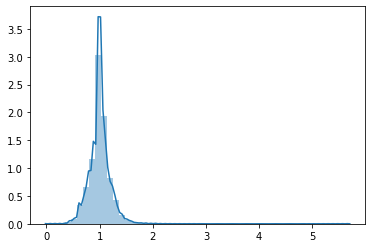

In [193]:
sns.distplot(cn.values)

# PCA & umap

In [7]:
mutation = pd.read_pickle(f"../data/CCLE_mutations_processed_filtered.pkl")
cn = pd.read_pickle(f"../data/CCLE_CN_processed_filtered.pkl")
rna = pd.read_pickle(f"../data/CCLE_RNA_processed_filtered.pkl")
protein = pd.read_pickle(f"../data/CCLE_protein_processed_filtered.pkl")
drug = pd.read_csv("../data/broad_drug_processed_auc.csv")

In [210]:
X = pd.concat([mutation, cn, rna, protein], axis=1)

X = SimpleImputer().fit_transform(X.values)

In [216]:
pca = PCA(n_components=30)
pca.fit(X)

In [221]:
pca_df = pd.DataFrame(pca.transform(X), index=mutation.index, columns=[f"PC{x+1}" for x in range(30)])

pca_df.to_csv("../data/drug/PCA.csv")

In [230]:
umap_df = umap.UMAP(random_state=42, n_components=30).fit_transform(X)

umap_df = pd.DataFrame(umap_df, index=mutation.index, columns=[f"UMAP_{x+1}" for x in range(30)])

In [232]:
umap_df.to_csv("../data/drug/UMAP.csv")

# early-concat

In [19]:
mutation = pd.read_pickle(f"../data/CCLE_mutations_processed_filtered.pkl")
cn = pd.read_pickle(f"../data/CCLE_CN_processed_filtered.pkl")
rna = pd.read_pickle(f"../data/CCLE_RNA_processed_filtered.pkl")
protein = pd.read_pickle(f"../data/CCLE_protein_processed_filtered.pkl")

In [20]:
protein = pd.DataFrame(SimpleImputer().fit_transform(protein.values), index=protein.index, columns=protein.columns)

In [21]:
mutation.columns = [f"{x}_mutation" for x in mutation.columns]

cn.columns = [f"{x}_cn" for x in cn.columns]

rna.columns = [f"{x}_rna" for x in rna.columns]

protein.columns = [f"{x}_protein" for x in protein.columns]

In [22]:
df_early_concat = pd.concat([mutation, cn, rna, protein], axis=1)

In [24]:
df_early_concat.to_csv("../data/ccle_early_concat.csv.gz")